In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"


In [2]:
!pip install pandas scikit-learn nltk tensorflow transformers torch


In [3]:
import pandas as pd
import os
from sklearn.utils import resample

#  Dataset directory
dataset_dir= r"C:\Users\HP\Downloads\NLP\NLP\iitp-movie-reviews\hi"

#  Load CSV dataset
def load_dataset(file_name):
    file_path = os.path.join(dataset_dir, file_name)
    if not os.path.exists(file_path):
        print(f" Error: File '{file_name}' not found at {file_path}")
        return None
    df = pd.read_csv(file_path, header=None, names=["sentiment", "review"])
    print(f" Loaded: {file_name} | Shape: {df.shape}")
    return df

#  Load datasets
train_df = load_dataset("train.csv")
valid_df = load_dataset("valid.csv")
test_df = load_dataset("test.csv")

#  Function to balance any dataset
def balance_dataset(df):
    class_counts = df["sentiment"].value_counts()
    min_count = class_counts.min()
    balanced = pd.concat([
        resample(df[df["sentiment"] == sentiment], n_samples=min_count, random_state=42)
        for sentiment in class_counts.index
    ])
    return balanced.sample(frac=1, random_state=42).reset_index(drop=True)

#  Balance all datasets
train_df = balance_dataset(train_df)
valid_df = balance_dataset(valid_df)
test_df = balance_dataset(test_df)

#  Show class distributions
print("\n Balanced Class Distribution:")
print("Train:\n", train_df["sentiment"].value_counts())
print("Validation:\n", valid_df["sentiment"].value_counts())
print("Test:\n", test_df["sentiment"].value_counts())

#  Show sample neutral reviews
neutral_train = train_df[train_df["sentiment"] == "neutral"]
neutral_valid = valid_df[valid_df["sentiment"] == "neutral"]
neutral_test = test_df[test_df["sentiment"] == "neutral"]

print("\n Neutral Reviews - Train:")
print(neutral_train.head(5))

print("\n Neutral Reviews - Validation:")
print(neutral_valid.head(5))

print("\n Neutral Reviews - Test:")
print(neutral_test.head(5))

#  Show count of neutral examples
print(f"\n📌 Total Neutral (Train): {len(neutral_train)}")
print(f"📌 Total Neutral (Valid): {len(neutral_valid)}")
print(f"📌 Total Neutral (Test):  {len(neutral_test)}")


 Loaded: train.csv | Shape: (2480, 2)
 Loaded: valid.csv | Shape: (310, 2)
 Loaded: test.csv | Shape: (310, 2)

 Balanced Class Distribution:
Train:
 sentiment
neutral     697
positive    697
negative    697
Name: count, dtype: int64
Validation:
 sentiment
positive    80
negative    80
neutral     80
Name: count, dtype: int64
Test:
 sentiment
positive    90
negative    90
neutral     90
Name: count, dtype: int64

 Neutral Reviews - Train:
   sentiment                                             review
0    neutral            समीर और संजीव चतुर्वेदी के गीत औसत हैं।
5    neutral  निर्माता :\nनीरज पाठक, कृष्ण चौधरी\n\nनिर्देशक...
14   neutral  यह रिश्ता उनकी इमेज, बातचीत और निभाए किरदारों ...
15   neutral  तीन संगीतकार ‍(हिमेश रेशमिया, आनंद राज आनंद और...
21   neutral  अनुराग कश्यप की फिल्म 'अग्ली' के इस शीर्षक गीत...

 Neutral Reviews - Validation:
   sentiment                                             review
5    neutral  श्रीजीत मुखर्जी ने अपनी बंगाली फिल्म 'राजकहिनी...
6    neutral 

In [4]:
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Define Hindi stopwords manually
hindi_stop_words = set([
    "है", "और", "था", "थे", "हैं", "कर", "रहा", "रहे", "इस", "कि", "जो", "तक", "ने", 
    "को", "पर", "से", "भी", "या", "लिए", "तो", "ही", "में", "यह", "थे", "था", "हो", 
    "गया", "दिया", "करना", "किया", "जा", "गई", "रखी", "रख", "वाले", "उनके", "उनकी",
    "इन", "उन", "कुछ", "कौन", "किस", "क्या", "कैसे", "कब", "कहाँ", "नहीं", "बाद",
    "बिना", "बड़ा", "बड़े", "होता", "जैसे", "जब", "लेकिन", "यदि"
])

# Optional: download punkt if needed for tokenization
nltk.download('punkt')

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = " ".join([word for word in text.split() if word not in hindi_stop_words])
    return text


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from sklearn.ensemble import RandomForestClassifier

# Preprocess data
train_df["clean_review"] = train_df["review"].apply(preprocess_text)
test_df["clean_review"] = test_df["review"].apply(preprocess_text)

# Vectorize
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_df["clean_review"])
X_test = tfidf.transform(test_df["clean_review"])

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_df["sentiment"])
y_test = le.transform(test_df["sentiment"])

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf.predict(X_test)
print("🎯 Random Forest Results:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))


🎯 Random Forest Results:
              precision    recall  f1-score   support

    negative       0.63      0.61      0.62        90
     neutral       0.57      0.44      0.50        90
    positive       0.51      0.64      0.57        90

    accuracy                           0.57       270
   macro avg       0.57      0.57      0.56       270
weighted avg       0.57      0.57      0.56       270



In [6]:
from sklearn.ensemble import RandomForestClassifier

# Preprocess data
train_df["clean_review"] = train_df["review"].apply(preprocess_text)
test_df["clean_review"] = test_df["review"].apply(preprocess_text)

# Vectorize
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_df["clean_review"])
X_test = tfidf.transform(test_df["clean_review"])

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_df["sentiment"])
y_test = le.transform(test_df["sentiment"])

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf.predict(X_test)
print("🎯 Random Forest Results:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))


🎯 Random Forest Results:
              precision    recall  f1-score   support

    negative       0.63      0.61      0.62        90
     neutral       0.57      0.44      0.50        90
    positive       0.51      0.64      0.57        90

    accuracy                           0.57       270
   macro avg       0.57      0.57      0.56       270
weighted avg       0.57      0.57      0.56       270



🌲 Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.58      0.61        90
     neutral       0.61      0.53      0.57        90
    positive       0.52      0.64      0.58        90

    accuracy                           0.59       270
   macro avg       0.59      0.59      0.59       270
weighted avg       0.59      0.59      0.59       270



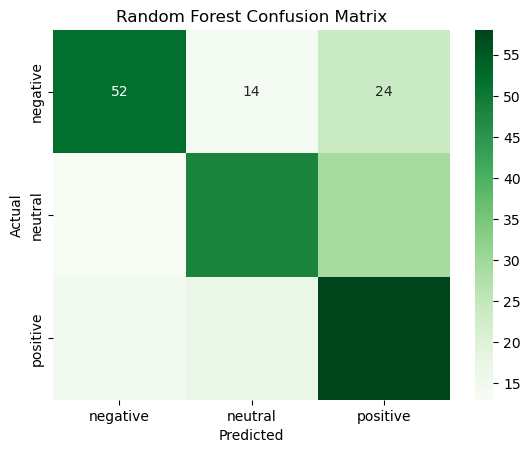

In [11]:

# Random Forest block
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df['clean_review']).toarray()
X_test_tfidf = tfidf.transform(test_df['clean_review']).toarray()

# Train RF
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluation
print("🌲 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


Epoch 1/10
59/59 [==============================] - 40s 383ms/step - loss: 1.0796 - accuracy: 0.4200 - val_loss: 1.0094 - val_accuracy: 0.4714
Epoch 2/10
59/59 [==============================] - 18s 311ms/step - loss: 0.7464 - accuracy: 0.6906 - val_loss: 0.7936 - val_accuracy: 0.7000
Epoch 3/10
59/59 [==============================] - 18s 309ms/step - loss: 0.3378 - accuracy: 0.8878 - val_loss: 0.6212 - val_accuracy: 0.7667
Epoch 4/10
59/59 [==============================] - 18s 307ms/step - loss: 0.1633 - accuracy: 0.9484 - val_loss: 0.7862 - val_accuracy: 0.7667
Epoch 5/10
59/59 [==============================] - 18s 311ms/step - loss: 0.0857 - accuracy: 0.9777 - val_loss: 0.9163 - val_accuracy: 0.7667
Epoch 6/10
59/59 [==============================] - 19s 315ms/step - loss: 0.0592 - accuracy: 0.9872 - val_loss: 0.9875 - val_accuracy: 0.7667
Epoch 7/10
59/59 [==============================] - 18s 312ms/step - loss: 0.0340 - accuracy: 0.9931 - val_loss: 1.0827 - val_accuracy: 0.7857

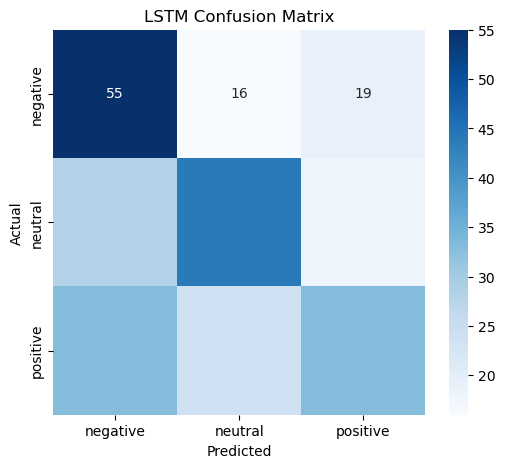

In [47]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Tokenize
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df["clean_review"])

X_train_seq = tokenizer.texts_to_sequences(train_df["clean_review"])
X_test_seq = tokenizer.texts_to_sequences(test_df["clean_review"])

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# LSTM Model (Improved)
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=True)

# Predict
y_pred_lstm = np.argmax(model.predict(X_test_pad), axis=1)

# Report
print("🎯 LSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()


In [48]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 🔮 Unified prediction function
def predict_sentiment(text):
    # Step 1: Preprocess
    cleaned = preprocess_text(text)

    # Step 2: Random Forest prediction using TF-IDF
    tfidf_input = tfidf.transform([cleaned])
    rf_raw_pred = rf.predict(tfidf_input)
    rf_pred = le.inverse_transform(rf_raw_pred)[0]

    # Step 3: LSTM prediction
    seq = tokenizer.texts_to_sequences([cleaned])
    pad_input = pad_sequences(seq, maxlen=100)
    lstm_prob = model.predict(pad_input, verbose=0)
    lstm_raw_pred = np.argmax(lstm_prob, axis=1)
    lstm_pred = le.inverse_transform(lstm_raw_pred)[0]

    # Step 4: Return predictions
    return {
        "Random Forest": rf_pred,
        "LSTM": lstm_pred,
    }


In [49]:
# 🔮 Unified prediction function
def predict_sentiment(text):
    cleaned = preprocess_text(text)
    
    # Random Forest prediction
    tfidf_input = tfidf.transform([cleaned])
    rf_pred = le.inverse_transform(rf.predict(tfidf_input))[0]

    # LSTM prediction
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=100)
    lstm_pred = le.inverse_transform([np.argmax(model.predict(pad), axis=1)[0]])[0]

   

    return {
        "Random Forest": rf_pred,
        "LSTM": lstm_pred,
        
    }

In [59]:
# 🔍 Test example
sample_text = " यह फिल्म औसत थी "
results = predict_sentiment(sample_text)

print("\n🔮 Predicted Sentiment:")
for model_name, sentiment in results.items():
    print(f"{model_name}: {sentiment}")


1/1 [==============================] - 0s 64ms/step

🔮 Predicted Sentiment:
Random Forest: positive
LSTM: neutral


In [ ]:
यह फिल्म औसत थी   यह एक बुरी फिल्म है   यह फिल्म बहुत अच्छी थी

In [60]:
# Save the trained LSTM model to an H5 file
model.save("sentiment_model.h5")
print("✅ Model saved as 'sentiment_model.h5'")

✅ Model saved as 'sentiment_model.h5'


C:\Users\HP\anaconda3\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
import pickle

# Save the tokenizer that was used during training
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ Tokenizer saved as 'tokenizer.pickle'")

✅ Tokenizer saved as 'tokenizer.pickle'
